# Segmentation Exudatae, Red Dot and Hemorrage from IDRiD dataset and DIARETDB1

#### Compiler (Adam)
#### Learning rate (0.0001)
#### Accuracy metric: Dice coefficient [9] to be maximized
#### Loss metric: negative Dice coefficient (to be minimized)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from matplotlib import pyplot as plt
from tensorflow import keras

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import math

import cv2
import os

WIDTH, HEIGHT = 1024, 1024
NUM_CLASSES = 3 # 0. Background, 1, Exudatas(Hard + Soft), 2. Red Dot + Hemorrhages + Microaneurysms
BATCH_SIZE = 1


EPOCHS = 100

# On Colab
MODEL_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/"
BASE_DIR = '/content/gdrive/MyDrive/Colab Notebooks/DR_data/'

# On windows Os
#MODEL_DIR = "C:/Users/yhu04/Diabetic Retinopathy/"
#BASE_DIR = "C:/Users/yhu04/DR_data/"


# 1. Construct Model
## 1.1. U-Net
#### 1.1.1. U-Net with VGG16

방식
1. get_backbone에서 백본을 얻고, output을 반환
2. Unet 함수에서 모델 반환

In [4]:
def get_backbone(width = WIDTH, height = HEIGHT):
    backbone = keras.applications.VGG16(include_top=False, input_shape=(width, height, 3), weights = "imagenet")
    output_0, output_1, output_2, output_3, output_4, fin_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block1_conv2","block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3", "block5_pool"]
    ]
        
    return keras.Model(
        inputs=[backbone.inputs],
        outputs=[ fin_output, output_4, output_3, output_2, output_1, output_0 ],
        )

In [18]:
def twice_Conv2D(input_image, num_filters, i):
    for j in range(2):
        output = keras.layers.Conv2D(num_filters, 3, 1, 
                                    padding = "same",
                                    kernel_initializer='he_normal',
                                    name=f"block{i+1}_Conv{j+1}")(input_image)
        output = keras.layers.BatchNormalization(name=f"block{i+1}_BN{j+1}")(output)
        output = keras.layers.ReLU(name = f"block{i+1}_ReLU{j+1}")(output)
    return output

def Unet(num_classes = NUM_CLASSES, width = WIDTH, height = HEIGHT):
    input_image = keras.Input(shape=(width, height, 3), name="Image")
    output_list = get_backbone()(input_image, training = False)
    output = output_list[0]
    for i in range(2):
        output = keras.layers.Conv2D(512, 3, 1, 
                                     padding = "same",
                                     kernel_initializer='he_normal',
                                     name=f"block{0}_Conv{i}")(output)
        output = keras.layers.BatchNormalization(name=f"block{0}_BN{i}")(output)
        output = keras.layers.ReLU(name=f"block{0}_ReLU{i}")(output)
    
    for i, filters in enumerate([256, 128, 64, 32, 16]):
        output = keras.layers.UpSampling2D(2, name=f"block{i+1}_UpSampling{0}")(output)
        output = keras.layers.Conv2D(output.shape[-1], 2, 1, 
                                     padding = "same",
                                     kernel_initializer='he_normal',
                                     name=f"block{i+1}_Conv{0}")(output)
        output = keras.layers.BatchNormalization(name=f"block{i+1}_BN{0}")(output)
        output = keras.layers.ReLU(name=f"block{i+1}_ReLU{0}")(output)
        output = keras.layers.concatenate([output, output_list[i+1]], name = f"block{i+1}_concat")
        output = twice_Conv2D(output, filters, i)
                
    output = keras.layers.Conv2D(num_classes, 1, 1, 
                                 padding = "same", 
                                 activation = "softmax", 
                                 kernel_initializer=tf.initializers.RandomNormal(0.0, 0.01),
                                 bias_initializer = tf.constant_initializer(-np.log((1 - 0.01) / 0.01)),
                                 name = f"block{5}_Conv_ReLU")(output)
    
    model = keras.models.Model(inputs = input_image, outputs=output)
    return model

backbone_name = "VGG16"
unet_vgg16 = Unet()
unet_vgg16.summary()

# 2. Loss Function
#### 2.1. Dice Loss
#### 2.2. IoU ( Jaccard Loss)
#### 2.3. Categorical Focal Loss + Dice Loss
#### 2.4. Categorical Focal Loss + Jaccard Loss

In [6]:
def Dice(y_true, y_pred, solo = True, num_classes = NUM_CLASSES):
    """
    Dice
    
    Dice = 2TP / (2TP + FP + FN) = 2|X∩Y| / (|X| + |Y|) 
         = sum(2 X*Y) / (sum(X) +sum(Y))
    """ 
    smooth = 0.0001
    if solo:
        y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32),
                            depth=num_classes,
                            dtype=tf.float32,
                            )
        
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return (numerator + smooth) / (denominator + smooth)

In [7]:
def Jaccard(y_true, y_pred, solo = True, num_classes = NUM_CLASSES):
    """
    Jaccard
    
    IoU = TP / (TP + FP + FN) = |X∩Y| / ( |X| + |Y| - |X∩Y| )
        = sum(A*B) / (sum(A)+sum(B)-sum(A*B))
    """
    smooth = 0.0001
    if solo:
        y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32),
                            depth=num_classes,
                            dtype=tf.float32,
                            )
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    sum_ = tf.reduce_sum(y_true + y_pred, axis=-1)
    return ((intersection + smooth) / (sum_ - intersection + smooth))

In [8]:
class CategoricalFocalLoss(tf.losses.Loss):
    """
    식 : loss = - y_true * alpha * ((1 - y_pred)^gamma) * log(y_pred)
        
    alpha: the same as weighting factor in balanced cross entropy, default 0.25
    gamma: focusing parameter for modulating factor (1-p), default 2.0

    y_true =  [[0., 1.0, 0.], [0., 0., 1.], [0., 1., 0.]]
    y_pred = [[0.70, 0.15, 0.15], [0.1, 0.8, 0.1], [0.25, 0.65, 0.1]]
    y_true = tf.cast(y_true, dtype= "float32")
    y_pred = tf.cast(y_pred, dtype= "float32")
    gamma=3.0
    alpha=0.25
    """
    def __init__(self, solo = True, num_classes = NUM_CLASSES, gamma = 2.0, alpha=0.25):
        super(CategoricalFocalLoss, self).__init__(reduction = 'auto', name = "CategoricalFocalLoss")
        self._num_classes = num_classes
        self._gamma = gamma
        self._alpha = alpha
        self._epsilon = 1e-07
        self.solo = solo
        
    def call(self, y_true, y_pred):
        if self.solo:
            y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32),
                                depth=self._num_classes,
                                dtype=tf.float32,
                                )

        y_pred = tf.clip_by_value(y_pred, self._epsilon, 1.0 - self._epsilon)
        loss = - y_true * self._alpha * tf.math.pow((1 - y_pred), self._gamma) * tf.math.log(y_pred)
        """
        Another Code
        alpha = tf.where(tf.equal(y_true, 1.), alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.), y_pred, 1-y_pred)
        y_pred = tf.add(y_pred, self._epsilon)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * tf.multiply(y_true, -tf.math.log(y_pred))
        """
        return tf.reduce_mean(loss)

# 3. Generator Dataset
## 3.1. Data Preprocessing
## 3.2. Data Augmentation

In [9]:
class Dataset_Generator():
    def __init__(self,
                 base_dir = BASE_DIR,
                 num_classes = NUM_CLASSES,
                 batch_size = BATCH_SIZE,
                 height = HEIGHT,
                 width = WIDTH,
                 epochs = EPOCHS,
                ):
        
        self.base_dir = BASE_DIR
        self.num_classes = float(num_classes)
        self.batch_size = batch_size
        self.height = HEIGHT
        self.width = WIDTH
        self.epochs = epochs
        #self.images_list = []
        self.images_list = os.listdir(self.base_dir + "Training/images/")
        random.shuffle(self.images_list)
        
    def __del__(self):
        print("Dataset Generator is destructed")
            
    def _preprocessor(self):
        """
        1. 전처리 전 디렉토리 구조
        
        /base_dir
            ├─image
            │   ├─ IDRiD_01.jpg
            │   ├─ IDRiD_02.jpg
            │   ├─ IDRiD_03.jpg
            │   ....
            │   ├─ image088.png
            │   └─ image089.png
            │
            └─mask
                ├─ MA
                │   ├─ IDRiD_01_MA.jpg
                │   ├─ IDRiD_02_MA.jpg
                │   ....
                │   ├─ image088.png
                │   └─ image089.png
                │ 
                ├─ HE
                │   ├─ IDRiD_01_HE.jpg
                │   ├─ IDRiD_02_HE.jpg
                │   ....
                │   ├─ image088.png
                │   └─ image089.png
                │ 
                ├─ EX
                │   ├─ IDRiD_01_EX.jpg
                │   ├─ IDRiD_02_EX.jpg
                │   ....
                │   ├─ image088.png
                │   └─ image089.png
                │ 
                └─ SE
                     ├─ IDRiD_01_SE.jpg
                     ├─ IDRiD_02_SE.jpg
                    ....
                     ├─ image088.png
                     └─ image089.png 


        2. 전처리 후 디렉토리 구조
        /base_dir
            ├─image
            ├─mask
            │   ├─ MA
            │   ├─ HE
            │   ├─ EX
            │   └─ SE
            │ 
            ├─ Training
            │   ├─ images
            │   └─ masks
            │
            └─ Test
                 ├─ images
                 └─ masks
        
        """
        # 전처리한 파일을 저장할 폴더 생성
        try:
            os.mkdir(self.base_dir+"Training")
            os.mkdir(self.base_dir+"Test")
            os.mkdir(self.base_dir+"Training/images")
            os.mkdir(self.base_dir+"Test/images")
            os.mkdir(self.base_dir+"Training/masks")
            os.mkdir(self.base_dir+"Test/masks")
        except FileExistsError:
            pass
        
        idrid_cnt = diaretdb_cnt = 0 # 훈련 set, 테스트 set 분할

        # 파일명 정리
        image_list = os.listdir(self.base_dir + "image/")
        for i, file_name in enumerate(image_list):
            image_list[i] = file_name.split(".")[0]
        image_list.sort()

        # 마스크 클래스 별
        mask_class_dir = ["MA", "HE", "EX", "SE"]
        mask_file_list = []

        for cls in mask_class_dir:
            mask_file_list.append(os.listdir(self.base_dir + f"mask/{cls}"))

        zero_1 = np.zeros([2848, 4288], dtype = np.uint8)
        zero_2 = np.zeros([1152, 1500], dtype = np.uint8)

        loss_cnt = 0
        # 전처리
        for i, file_name in enumerate(image_list):
            if "IDRiD" in file_name:
                zero = zero_1
                thres = 1
            elif "image" in file_name:
                zero = zero_2
                # [63, 127, 189, 252]
                thres = 127

            mask_list = []
            # 1. mask  파일 찾기
            for cls in range(4):
                # 1.1. 파일명 확정
                if "IDRiD" in file_name:
                    mask_file_name = f"{file_name}_{mask_class_dir[cls]}.tif"
                elif "image" in file_name:
                    mask_file_name = f"{file_name}.png"

                # 1.2. 마스크 유무 확인
                if mask_file_name in mask_file_list[cls]:
                    mask = cv2.imread(f"{self.base_dir}mask/{mask_class_dir[cls]}/{mask_file_name}", 0)
                    _, mask = cv2.threshold(mask, thres, 1, cv2.THRESH_BINARY)
                else:
                    mask = zero
                mask_list.append(mask)

            # 2. 마스크 통합
            Class_1 = cv2.bitwise_or(mask_list[0], mask_list[1]) * 100
            Class_2 = cv2.bitwise_or(mask_list[2], mask_list[3]) * 200
            mask = Class_1 + Class_2
            del Class_1, Class_2, mask_list

            # 빈 마스크 확인
            if np.all(mask == zero):
                loss_cnt += 1
                print(f"{file_name} has no mask")
            else:
                # 5.0. Binaryzation
                # 5.1. 파일명 확정
                if "IDRiD" in file_name:
                    file_name = f"{file_name}.jpg"
                elif "image" in file_name:
                    file_name = f"{file_name}.png"
                img = cv2.imread(f"{self.base_dir}image/{file_name}")

                # 5.2 IDRiD 데이터셋에서만 crop 과정
                if "IDRiD" in file_name:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    if i==3 or i == 10:
                        thres = 10
                    else:
                        thres = 30

                    _, binary_img = cv2.threshold(gray_img, thres, 255, cv2.THRESH_BINARY)
                    del gray_img

                    # 5.2.1. contours
                    contours, hierachy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                    # 5.2.2 x_min, x_max 찾기
                    x_min = np.min(contours[-1], axis = 0)
                    x_max = np.max(contours[-1], axis = 0)
                    x_min, x_max = x_min[0][0], x_max[0][0]
                    del contours, hierachy

                    # 5.2.3. Crop
                    img = img[:, x_min:x_max+1]
                    mask = mask[:, x_min:x_max+1]

                    # 6. Padding
                    if (x_max-x_min)/2848 >= 1.25:
                        pad_left, pad_right = 0, 0
                    else:
                        pad_left, pad_right = 200, 200

                    img = cv2.copyMakeBorder(img, 500, 500, pad_left, pad_right, cv2.BORDER_CONSTANT,value=0)
                    mask = cv2.copyMakeBorder(mask, 500, 500, pad_left, pad_right, cv2.BORDER_CONSTANT,value=0)

                # 5.3. diaretdb에서는 Padding만
                elif "image" in file_name:
                    img = cv2.copyMakeBorder(img, 174, 174, 0, 0, cv2.BORDER_CONSTANT,value=0)
                    mask = cv2.copyMakeBorder(mask, 174, 174, 0, 0, cv2.BORDER_CONSTANT,value=0)

                # 7. Resize
                img = cv2.resize(img, dsize=(self.height, self.width), interpolation=cv2.INTER_AREA)
                mask = cv2.resize(mask, dsize=(self.height, self.width), interpolation=cv2.INTER_AREA)

                # 8. 파일 저장
                # 훈련, 테스트셋 별도 저장
                if "IDRiD" in file_name and idrid_cnt < 60:
                    cv2.imwrite(f'{self.base_dir}Training/images/{file_name}', img)
                    cv2.imwrite(f'{self.base_dir}Training/masks/{file_name}', mask)
                    idrid_cnt += 1

                elif "IDRiD" in file_name and idrid_cnt >= 60:
                    cv2.imwrite(f'{self.base_dir}Test/images/{file_name}', img)
                    cv2.imwrite(f'{self.base_dir}Test/masks/{file_name}', mask)
                    idrid_cnt += 1

                elif "image" in file_name and diaretdb_cnt < 40:
                    cv2.imwrite(f'{self.base_dir}Training/images/{file_name}', img)
                    cv2.imwrite(f'{self.base_dir}Training/masks/{file_name}', mask)
                    diaretdb_cnt += 1

                elif "image" in file_name and diaretdb_cnt >= 40:
                    cv2.imwrite(f'{self.base_dir}Test/images/{file_name}', img)
                    cv2.imwrite(f'{self.base_dir}Test/masks/{file_name}', mask)
                    diaretdb_cnt += 1

                print(f"{file_name} completed!")
        self.images_list = os.listdir(self.base_dir + "Training/images/")
        random.shuffle(self.images_list)
        print(f"Preprocessing completed!. Number of no mask data : {loss_cnt}")
    
    def _Image_Reshape(self, image, mask):
        image = np.reshape(image, ((self.batch_size,) + image.shape))
        mask = np.reshape(mask, ((self.batch_size,) + mask.shape))
        return (image/255, mask/200.)
    
    def train_generator(self, k):
        """
        Training Data Augmentation
        """
        # 전처리 했으면 skip, 전처리 안했으면 Go!
        if self.images_list:
            pass
        else:
            self._preprocessor()
        x_center, y_center = self.width/2, self.height/2

        for _ in range(self.epochs):
            for i, file_name in enumerate(self.images_list):
                if 20*k-20 <= i < 20*k:
                    pass
                else:
                    # 원본 이미지
                    img = cv2.imread(f"{self.base_dir}Training/images/{file_name}")
                    mask = cv2.imread(f"{self.base_dir}Training/masks/{file_name}", 0)
                    yield self._Image_Reshape(img, mask)

                    # 좌우 반전
                    flip_img = cv2.flip(img, 1)
                    flip_mask = cv2.flip(mask, 1)
                    yield self._Image_Reshape(flip_img, flip_mask)

                    for degree in range(90, 360, 90):
                        matrix = cv2.getRotationMatrix2D((x_center, y_center), degree, 1)
                            
                        # 원본 이미지에 대한 회전
                        rot_img = cv2.warpAffine(img, matrix, (self.width, self.height))
                        rot_mask = cv2.warpAffine(mask, matrix, (self.width, self.height))
                        yield self._Image_Reshape(rot_img, rot_mask)

                        # filp 이미지에 대한 회전
                        rot_flip_img = cv2.warpAffine(flip_img, matrix, (self.width, self.height))
                        rot_flip_mask = cv2.warpAffine(flip_mask, matrix, (self.width, self.height))
                        yield self._Image_Reshape(rot_flip_img, rot_flip_mask)


    def valid_generator(self, k):
        """
        Validataion Data Augmentation
        """
        x_center, y_center = self.width/2, self.height/2
        for _ in range(self.epochs):
            for i, file_name in enumerate(self.images_list):
                if (20*k-20) <= i < 20*k:
                    # 원본 이미지
                    img = cv2.imread(f"{self.base_dir}Training/images/{file_name}")
                    mask = cv2.imread(f"{self.base_dir}Training/masks/{file_name}", 0)
                    yield self._Image_Reshape(img, mask)

                    # 좌우 반전
                    flip_img = cv2.flip(img, 1)
                    flip_mask = cv2.flip(mask, 1)
                    yield self._Image_Reshape(flip_img, flip_mask)

                    for degree in range(90, 360, 90):
                        matrix = cv2.getRotationMatrix2D((x_center, y_center), degree, 1)
                            
                        # 원본 이미지에 대한 회전
                        rot_img = cv2.warpAffine(img, matrix, (self.width, self.height))
                        rot_mask = cv2.warpAffine(mask, matrix, (self.width, self.height))
                        yield self._Image_Reshape(rot_img, rot_mask)

                        # filp 이미지에 대한 회전
                        rot_flip_img = cv2.warpAffine(flip_img, matrix, (self.width, self.height))
                        rot_flip_mask = cv2.warpAffine(flip_mask, matrix, (self.width, self.height))
                        yield self._Image_Reshape(rot_flip_img, rot_flip_mask)


                
    def test_generator(self):
        images_list = os.listdir(self.base_dir + "Test/images/")
        for i, file_name in enumerate(images_list):
            # 원본 이미지
            img = cv2.imread(f"{self.base_dir}Test/images/{file_name}")
            mask = cv2.imread(f"{self.base_dir}Test/masks/{file_name}", 0)
            yield self._Image_Reshape(img, mask)

In [ ]:
## Training dataset check
dataset = Dataset_Generator()

gen = dataset.train_generator(1)
for i in range(720 * 4):
    result = next(gen)
    img, mask = result[0][0], result[1][0]

    fig = plt.figure(i, figsize = (10,10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)
    ax1.set_title('Image')
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(mask, cmap = "bone")
    ax2.set_title('Ground Truth Mask')
    ax2.axis("off")
    if i == 3:
        break

In [ ]:
## Validation dataset check
gen = dataset.valid_generator(1)
for i in range(720):
    result = next(gen)
    img, mask = result[0][0], result[1][0]
    fig = plt.figure(i, figsize = (10,10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)
    ax1.set_title('Image')
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(mask, cmap = "bone")
    ax2.set_title('Ground Truth Mask')
    ax2.axis("off")
    if i == 3:
        break

In [ ]:
## Test dataset
test_dataset = tf.data.Dataset.from_generator(
                    dataset.test_generator,
                    (tf.float32, tf.int32),
                    (tf.TensorShape([1, HEIGHT, WIDTH, 3]), tf.TensorShape([1,  HEIGHT, WIDTH])),
                    )

del dataset

### Check Test set test
for i, element in enumerate(test_dataset):
    img = element[0][0].numpy()
    mask = element[1][0].numpy()
    fig = plt.figure(i, figsize = (10,10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)
    ax1.set_title('Image')
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(mask, cmap = "bone")
    ax2.set_title('Ground Truth Mask')
    ax2.axis("off")
    
    if i == 3:
        break
    plt.show()

del gen, test_dataset

# 5. Training the Model and Evaluation
### - 성능 평가 지표 : Dice Coefficient, IoU

In [23]:
class MODEL():
    def __init__(self,
                 model_dir = MODEL_DIR,
                 batch_size = BATCH_SIZE,
                 width = WIDTH,
                 height = HEIGHT,
                 k = 0,
                ):
        
        self.batch_size = batch_size
        self.loss_fn = CategoricalFocalLoss()

        self.optimizer =  tf.keras.optimizers.Adam(learning_rate=0.00005)
        self.generator = Dataset_Generator()
        self.model_dir = MODEL_DIR
        self.optimal_k = k

        self.test_dataset = tf.data.Dataset.from_generator(
                        self.generator.test_generator,
                        (tf.float32, tf.int32),
                        (tf.TensorShape([1, HEIGHT, WIDTH, 3]), tf.TensorShape([1,  HEIGHT, WIDTH])),
                        )
        self.width = width
        self.height = height
    
    def __del__(self):
        print("MODEL is destructed")

    def Run_training(self, epochs= EPOCHS):        
        print("Mdoel Complie....")        
        
        # K-fold: k = 5
        K = 5
        mean_Dice = mean_IoU = 0
        DiceIoU_list = []
        for k in range(1, K+1):
            model = Unet()
            model.compile(loss = self.loss_fn, 
                          optimizer = self.optimizer,
                          metrics = [Dice, Jaccard]
                          )
            callbacks_list = [tf.keras.callbacks.ModelCheckpoint(
                                        filepath=os.path.join(
                                            f"{self.model_dir}U-Net_{k}.h5"),
                                        #monitor="val_loss",
                                        monitor="val_Dice",
                                        mode = "max",
                                        save_best_only=True,
                                        save_weights_only=True,
                                        verbose=1,
                                        ),
                              tf.keras.callbacks.EarlyStopping(
                                        #monitor = 'val_loss',
                                        monitor="val_Dice",
                                        mode = "max",
                                        min_delta = 0.01,
                                        patience = 5,
                                        )
                              ]
            print(f"{k}th fold Start Training....")
            
            history = model.fit(self.generator.train_generator(k),
                                steps_per_epoch = (K-1) * 20 * 8,
                                validation_data = self.generator.valid_generator(k),
                                validation_steps = 20 * 8,
                                callbacks = callbacks_list,
                                epochs = epochs,
                                batch_size = self.batch_size,
                                shuffle = True,
                                )
            
            loss = history.history['loss']
            val_loss = history.history['val_loss']
            dice = history.history["Dice"]
            val_dice = history.history["val_Dice"]
            iou = history.history["Jaccard"]
            val_iou = history.history["val_Jaccard"]
            
            DiceIoU_list.append( val_dice[-1] + val_iou[-1] )
            mean_Dice += val_dice[-1]
            mean_IoU += val_iou[-1]

            epochs_range = range(len(loss))
            
            plt.figure(k, figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.plot(epochs_range, loss, label='Training Loss')
            plt.plot(epochs_range, val_loss, label='Validation Loss')
            plt.legend(loc='upper right')
            plt.title('Loss')

            plt.subplot(1, 3, 2)
            plt.plot(epochs_range, dice, label='Training Dice')
            plt.plot(epochs_range, val_dice, label='Validation Dice')
            plt.legend(loc='lower right')
            plt.title('Dice Coefficient')

            plt.subplot(1, 3, 3)
            plt.plot(epochs_range, iou, label='Training IoU')
            plt.plot(epochs_range, val_iou, label='Validation IoU')
            plt.legend(loc='lower right')
            plt.title('IoU')
            plt.show()

            input_image = tf.keras.Input(shape=(self.width, self.height, 3), name="image")
            predictions = model(input_image, training = True)
            inference_model = tf.keras.Model(inputs=input_image, outputs=predictions)

            for i, test in enumerate(self.test_dataset):
                img, mask = test
                prediction = inference_model.predict(img)
                
                img = img[0].numpy()
                mask = mask[0].numpy()

                prediction = prediction[0]
                prediction = tf.math.argmax(prediction, -1)
                prediction = prediction.numpy()
                
                fig = plt.figure(10, figsize = (20,20))
                ax1 = fig.add_subplot(1, 3, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax1.imshow(img)
                ax1.set_title('Image')
                ax1.axis("off")

                ax2 = fig.add_subplot(1, 3, 2)
                ax2.imshow(mask)
                ax2.set_title('Ground Truth Mask')
                ax2.axis("off")

                ax3 = fig.add_subplot(1, 3, 3)
                ax3.imshow(prediction)
                ax3.set_title('Prediction')
                ax3.axis("off")
                plt.show()

                if i == 1:
                    break
            del model
        print("Training End\n\n")
        self.optimal_k = DiceIoU_list.index(max(DiceIoU_list)) + 1
        print(f"K-Fold Cross Validation Result\nmDice : {mean_Dice*20:.3f}, mIoU : {mean_IoU*20:.3f}, Optimal_K : {self.optimal_k}\n\n")

        
    def Evaluation(self, num_sample):
        input_image = tf.keras.Input(shape=(self.width, self.height, 3), name="image")
        model = Unet()
        model.load_weights(
            f"{self.model_dir}U-Net_{self.optimal_k}.h5")

        model.compile(loss = self.loss_fn, 
                      optimizer = self.optimizer,
                      metrics = [Dice, Jaccard]
                      )

        _, dice, iou = model.evaluate(self.test_dataset, batch_size = self.batch_size, verbose= 1)
        print(f"\n\nDice : {dice*100:.3f}, IoU : {iou*100:.3f}\n\n")
        predictions = model(input_image, training=True)
        inference_model = tf.keras.Model(inputs=input_image, outputs=predictions)
        
        print("Display predictions")
        for i, test in enumerate(self.test_dataset):
            img, mask = test
            prediction = inference_model.predict(img)
            
            img = img[0].numpy()
            mask = mask[0].numpy()

            prediction = prediction[0]
            prediction = tf.math.argmax(prediction, -1)
            prediction = prediction.numpy()
            
            fig = plt.figure(i, figsize = (20,20))
            ax1 = fig.add_subplot(1, 3, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax1.imshow(img)
            ax1.set_title('Image')
            ax1.axis("off")

            ax2 = fig.add_subplot(1, 3, 2)
            ax2.imshow(mask)
            ax2.set_title('Ground Truth Mask')
            ax2.axis("off")

            ax3 = fig.add_subplot(1, 3, 3)
            ax3.imshow(prediction)
            ax3.set_title('Prediction')
            ax3.axis("off")
            plt.show()

            if i == num_sample:
                break

Mdoel Complie....
1th fold Start Training....
Epoch 1/100
MODEL is destructed
MODEL is destructed
640/640 [==============================] - 135s 207ms/step - loss: 0.0225 - Dice: 0.4485 - Jaccard: 0.2927 - val_loss: 0.0107 - val_Dice: 0.5611 - val_Jaccard: 0.3930

Epoch 00001: val_Dice improved from -inf to 0.56106, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_1.h5
Epoch 2/100
640/640 [==============================] - 132s 207ms/step - loss: 0.0053 - Dice: 0.6506 - Jaccard: 0.4848 - val_loss: 0.0106 - val_Dice: 0.5947 - val_Jaccard: 0.4357

Epoch 00002: val_Dice improved from 0.56106 to 0.59468, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_1.h5
Epoch 3/100
640/640 [==============================] - 132s 207ms/step - loss: 0.0031 - Dice: 0.7287 - Jaccard: 0.5772 - val_loss: 0.0043 - val_Dice: 0.7313 - val_Jaccard: 0.5853

Epoch 00003: val_Dice improved from 0.59468 to 0.73127, saving model 

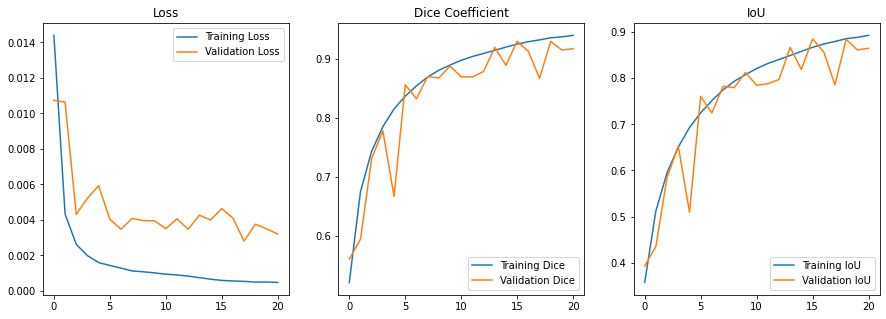

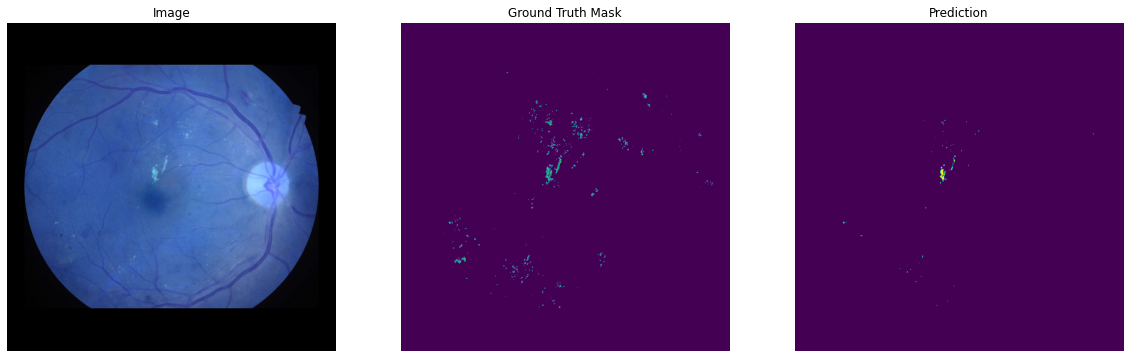

2th fold Start Training....
Epoch 1/100
640/640 [==============================] - 135s 207ms/step - loss: 0.0233 - Dice: 0.4422 - Jaccard: 0.2872 - val_loss: 0.0074 - val_Dice: 0.6257 - val_Jaccard: 0.4605

Epoch 00001: val_Dice improved from -inf to 0.62570, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_2.h5
Epoch 2/100
640/640 [==============================] - 132s 207ms/step - loss: 0.0058 - Dice: 0.6422 - Jaccard: 0.4757 - val_loss: 0.0059 - val_Dice: 0.6565 - val_Jaccard: 0.4940

Epoch 00002: val_Dice improved from 0.62570 to 0.65651, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_2.h5
Epoch 3/100
640/640 [==============================] - 132s 207ms/step - loss: 0.0035 - Dice: 0.7205 - Jaccard: 0.5674 - val_loss: 0.0037 - val_Dice: 0.7473 - val_Jaccard: 0.6032

Epoch 00003: val_Dice improved from 0.65651 to 0.74735, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retino

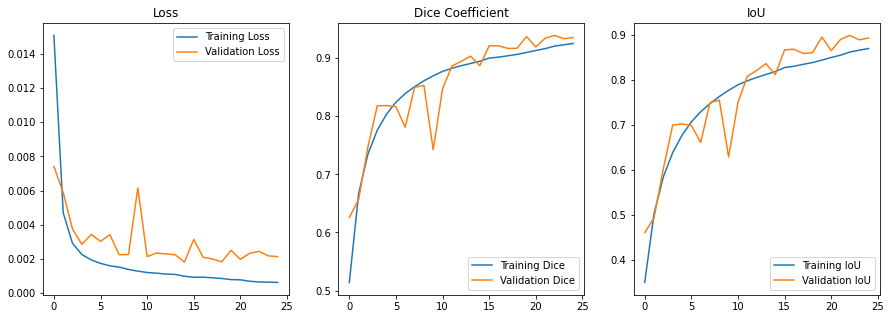

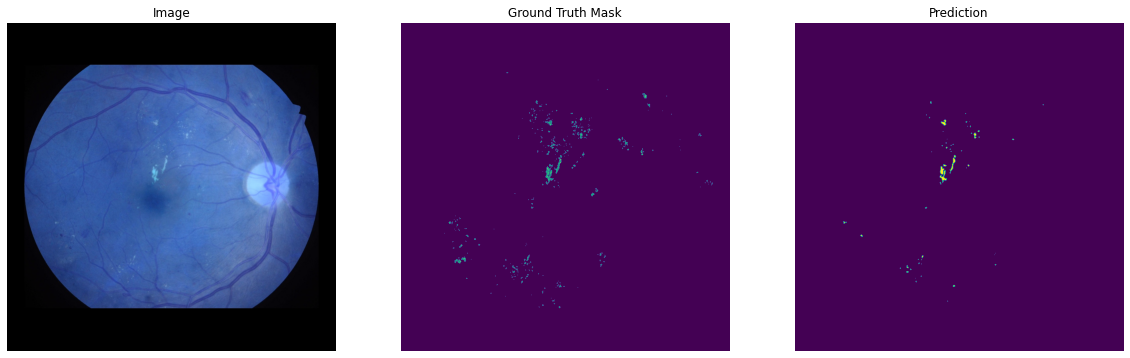

3th fold Start Training....
Epoch 1/100
640/640 [==============================] - 136s 208ms/step - loss: 0.0237 - Dice: 0.4397 - Jaccard: 0.2853 - val_loss: 0.0074 - val_Dice: 0.6056 - val_Jaccard: 0.4375

Epoch 00001: val_Dice improved from -inf to 0.60560, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_3.h5
Epoch 2/100
640/640 [==============================] - 133s 207ms/step - loss: 0.0059 - Dice: 0.6428 - Jaccard: 0.4767 - val_loss: 0.0033 - val_Dice: 0.7061 - val_Jaccard: 0.5478

Epoch 00002: val_Dice improved from 0.60560 to 0.70611, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_3.h5
Epoch 3/100
640/640 [==============================] - 133s 207ms/step - loss: 0.0035 - Dice: 0.7214 - Jaccard: 0.5689 - val_loss: 0.0025 - val_Dice: 0.7449 - val_Jaccard: 0.5977

Epoch 00003: val_Dice improved from 0.70611 to 0.74492, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retino

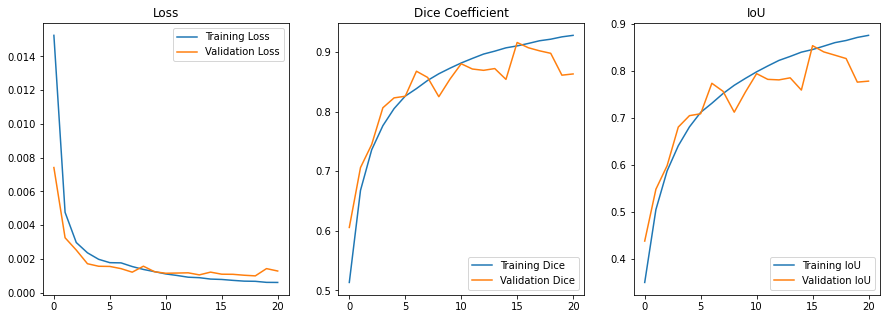

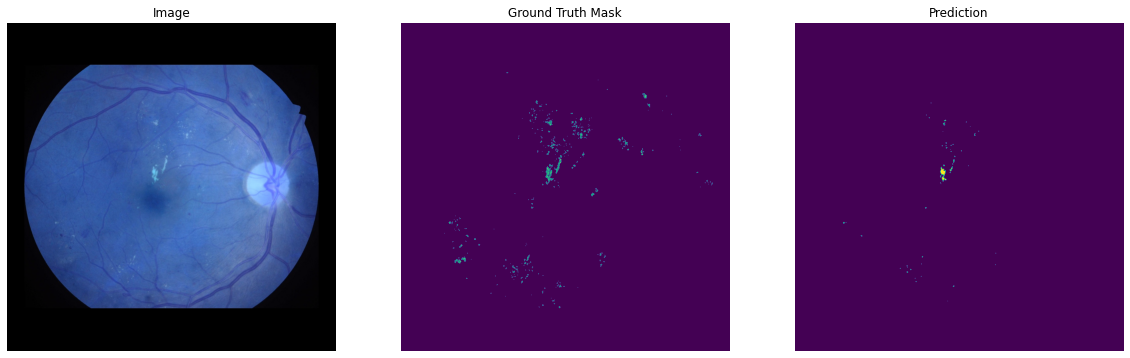

4th fold Start Training....
Epoch 1/100
640/640 [==============================] - 136s 209ms/step - loss: 0.0229 - Dice: 0.4467 - Jaccard: 0.2913 - val_loss: 0.0057 - val_Dice: 0.6330 - val_Jaccard: 0.4644

Epoch 00001: val_Dice improved from -inf to 0.63296, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_4.h5
Epoch 2/100
640/640 [==============================] - 133s 208ms/step - loss: 0.0058 - Dice: 0.6462 - Jaccard: 0.4808 - val_loss: 0.0030 - val_Dice: 0.7193 - val_Jaccard: 0.5659

Epoch 00002: val_Dice improved from 0.63296 to 0.71935, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_4.h5
Epoch 3/100
640/640 [==============================] - 133s 208ms/step - loss: 0.0035 - Dice: 0.7242 - Jaccard: 0.5727 - val_loss: 0.0041 - val_Dice: 0.6994 - val_Jaccard: 0.5461

Epoch 00003: val_Dice did not improve from 0.71935
Epoch 4/100
640/640 [==============================] - 133s 208ms/step - los

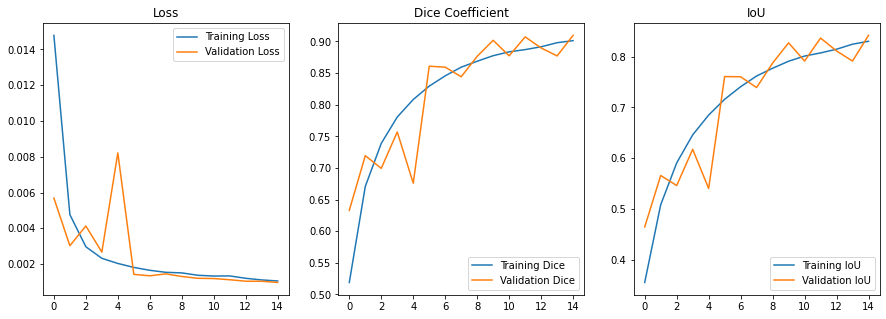

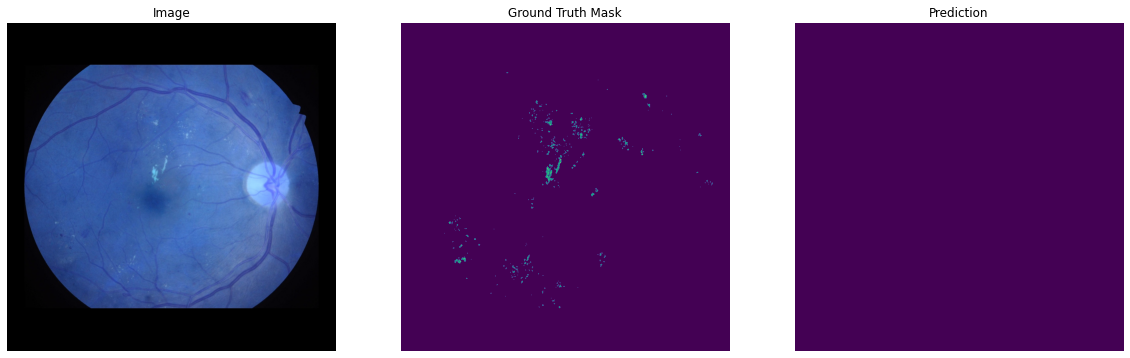

5th fold Start Training....
Epoch 1/100
640/640 [==============================] - 137s 210ms/step - loss: 0.0233 - Dice: 0.4425 - Jaccard: 0.2876 - val_loss: 0.0096 - val_Dice: 0.5656 - val_Jaccard: 0.3960

Epoch 00001: val_Dice improved from -inf to 0.56562, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_5.h5
Epoch 2/100
640/640 [==============================] - 134s 209ms/step - loss: 0.0059 - Dice: 0.6421 - Jaccard: 0.4759 - val_loss: 0.0032 - val_Dice: 0.7180 - val_Jaccard: 0.5640

Epoch 00002: val_Dice improved from 0.56562 to 0.71795, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diabetic Retinopathy/U-Net_VGG16+CFL_5.h5
Epoch 3/100
640/640 [==============================] - 133s 209ms/step - loss: 0.0037 - Dice: 0.7201 - Jaccard: 0.5674 - val_loss: 0.0068 - val_Dice: 0.6633 - val_Jaccard: 0.5122

Epoch 00003: val_Dice did not improve from 0.71795
Epoch 4/100
640/640 [==============================] - 133s 209ms/step - los

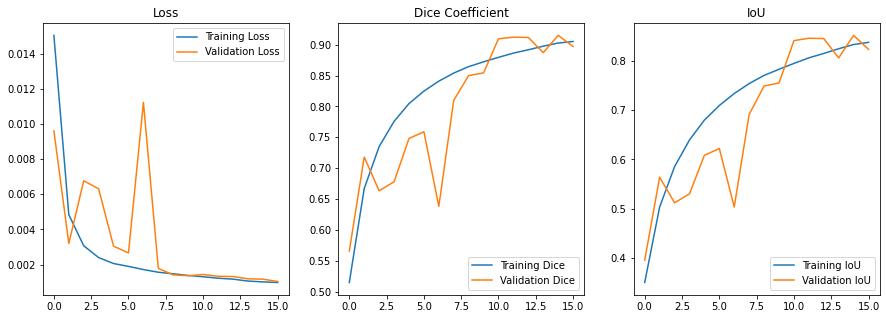

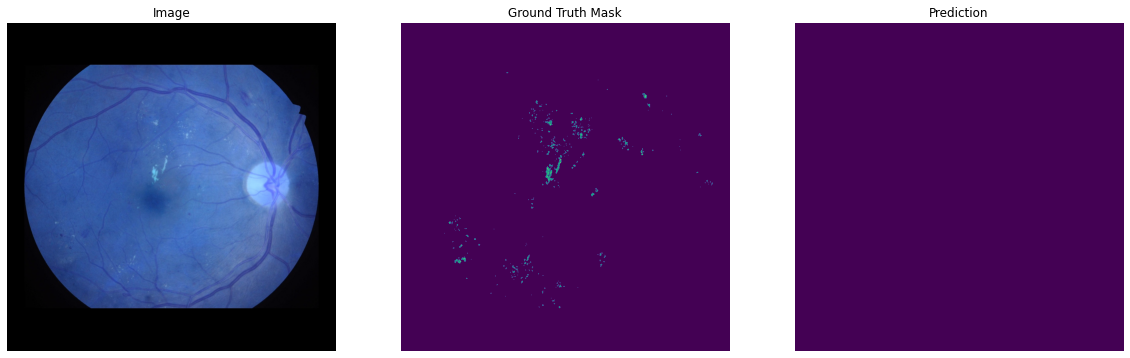

Training End


K-Fold Cross Validation Result
mDice : 90.444, mIoU : 84.016, Optimal_K : 2


36/36 [==============================] - 4s 94ms/step - loss: 8.9550e-04 - Dice: 0.9515 - Jaccard: 0.9134


U-Net_VGG16, CFL
Dice : 94.959, IoU : 90.995


Display predictions


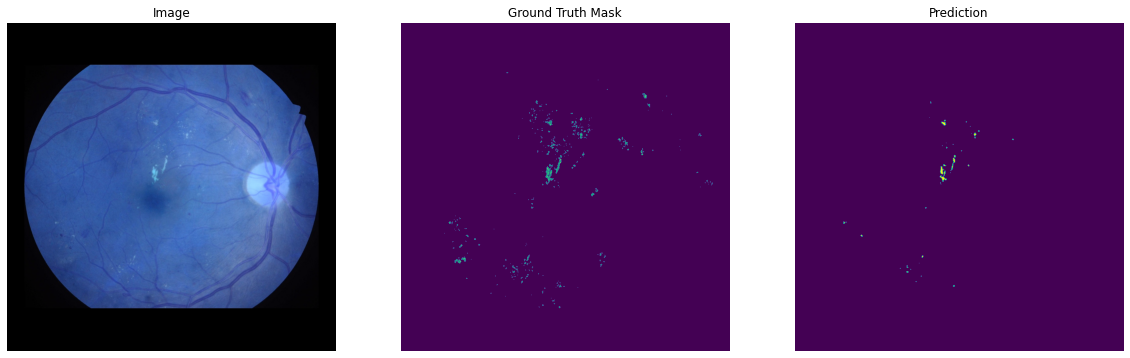

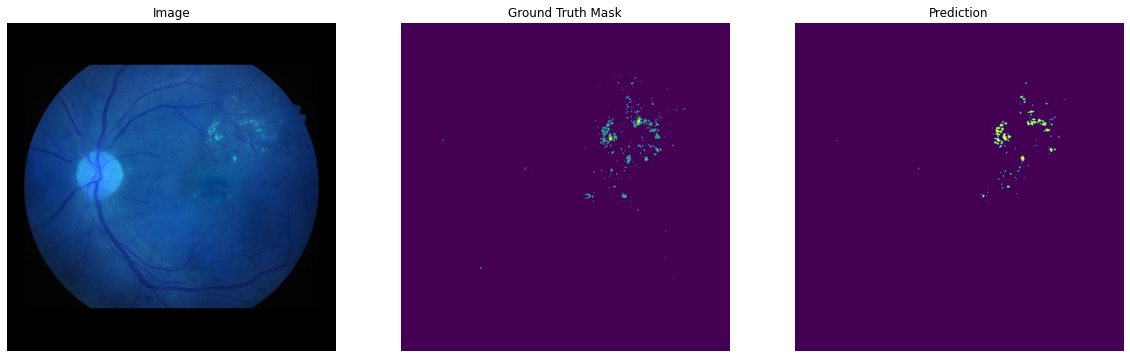

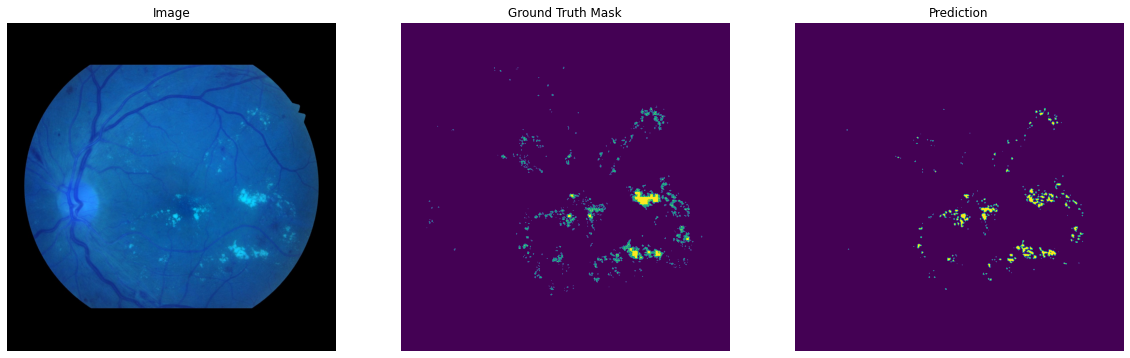

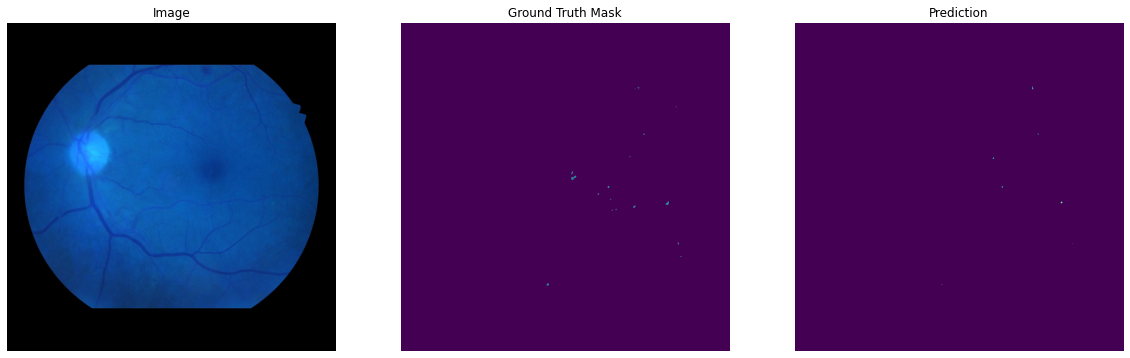

MODEL is destructed


In [ ]:
# VGG16 + CFLoss
vgg_CFL = MODEL()
vgg_CFL.Run_training()
vgg_CFL.Evaluation(num_sample = -1)
del vgg_CFL

In [24]:
vgg_CFL = MODEL(k = 2)
vgg_CFL.Evaluation(num_sample = -1)

Output hidden; open in https://colab.research.google.com to view.